<a href="https://colab.research.google.com/github/dupeljan/graph_emb_lab/blob/main/DLyakhov_graph_embeddings_small_training_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Node Classification without Graph Neural Networks by graph embeddings

## Setup

In [1]:
!pip install spektral==0.6.2 -q

In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import gensim
import spektral

# Graph embeddings for baseline NN model

Let's encode structural information of graph into embeddings and try to feed this to the baseline model. Let's decode terms information to latent space of $R^{d}$ and then mix them with structural info of the model

## Spektral cora dataset load


In [3]:
edges, features, labels, train_mask, val_mask, test_mask = spektral.datasets.citation.load_data(dataset_name='cora')

Loading cora dataset
Pre-processing node features


Verify train train val test masks shapes

In [4]:
edges.shape, features.shape, labels.shape, train_mask.shape, val_mask.shape, test_mask.shape

((2708, 2708), (2708, 1433), (2708, 7), (2708,), (2708,), (2708,))

Verify sizes

In [5]:
sum(train_mask), sum(test_mask), sum(val_mask)

(140, 1000, 500)

### Compare with the Dataset from archive

The Cora dataset consists of 2,708 scientific papers classified into one of seven classes.
The citation network consists of 5,429 links. Each paper has a binary word vector of size
1,433, indicating the presence of a corresponding word.

Download the dataset

The dataset has two tap-separated files: `cora.cites` and `cora.content`.

1. The `cora.cites` includes the citation records with two columns:
`cited_paper_id` (target) and `citing_paper_id` (source).
2. The `cora.content` includes the paper content records with 1,435 columns:
`paper_id`, `subject`, and 1,433 binary features.

Let's download the dataset.

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

180224/168052 [================================] - 0s 1us/step


#### Process and visualize the dataset

Then we load the citations data into a Pandas DataFrame.

In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


Now we display a sample of the `citations` DataFrame.
The `target` column includes the paper ids cited by the paper ids in the `source` column.

In [ ]:
citations.sample(frac=1).head()

,target,source
3585,73146,1108389
314,910,5462
2537,27535,34961
3060,40151,1152307
2045,15984,158098


Now let's load the papers data into a Pandas DataFrame.

In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


Now we display a sample of the `papers` DataFrame. The DataFrame includes the `paper_id`
and the `subject` columns, as well as 1,433 binary column representing whether a term exists
in the paper or not.

Let's display the count of the papers in each subject.

In [ ]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


We convert the paper ids and the subjects into zero-based indices.

In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

#### Check datasets are isomorphic

In [18]:
citations

,target,source
0,0,21
1,0,905
2,0,906
3,0,1909
4,0,1940
...,...,...
5424,1873,328
5425,1873,1876
5426,1874,2586
5427,1876,1874


In [49]:
y_pd = papers.sort_values('paper_id')['subject'].to_numpy()

In [56]:
y_pd

array([1, 1, 4, ..., 5, 5, 5])

In [60]:
y_sk = np.argmax(labels, axis=1)
y_sk

array([3, 4, 4, ..., 3, 3, 3])

In [61]:
{x: sum((y_sk == x).astype(int)) for x in range(7)}

{0: 351, 1: 217, 2: 418, 3: 818, 4: 426, 5: 298, 6: 180}

In [58]:
{x: sum((y_pd == x).astype(int)) for x in range(7)}

{0: 298, 1: 418, 2: 818, 3: 426, 4: 217, 5: 180, 6: 351}

In [20]:
# Read graph
weighted_citation = citations.copy()
weighted_citation['weight'] = 1
weighted_citation
nx_graph_pd = nx.from_pandas_edgelist(weighted_citation, edge_attr=['weight'])
nx_graph_pd.nodes.__len__()

2708

In [62]:
# Read graph
nx_graph = nx.convert_matrix.from_numpy_array(edges.toarray())
nx.set_node_attributes(nx_graph, 1, 'weight')
nx_graph.nodes.__len__()

2708

In [43]:
import networkx.algorithms.isomorphism as iso

sum(dict(nx_graph.degree(nx_graph.nodes())).values())

10556

In [44]:
sum(dict(nx_graph_pd.degree(nx_graph_pd.nodes())).values())

10556

## Node2Vec

In [6]:
P = Q = 1
DIRECTED = True
NUM_WALKS = 20
WALK_LEN = 50
WINDOW_LEN = 5
LATENT_DIM_LEN = 100
DROPOUT_RATE = 0.01

## Implementation 0

Random walk graph implementation

In [7]:
class Graph():
	def __init__(self, nx_G, is_directed, p, q):
		self.G = nx_G
		self.is_directed = is_directed
		self.p = p
		self.q = q

	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print('Walk iteration:')
		for walk_iter in range(num_walks):
			print(str(walk_iter+1), '/', str(num_walks))
			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks

	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs)

	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G
		is_directed = self.is_directed

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}
		for edge in G.edges():
				if not is_directed:
						alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
				else:
						alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
						alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return

def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

In [8]:
# Read graph
nx_graph = nx.convert_matrix.from_numpy_array(edges.toarray())
nx.set_node_attributes(nx_graph, 1, 'weight')
nx_graph.nodes.__len__()

2708

In [9]:
# Make random walks
G = Graph(nx_graph, DIRECTED, P, Q)
G.preprocess_transition_probs()
walks = np.array(G.simulate_walks(NUM_WALKS, WALK_LEN))

Walk iteration:
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


In [10]:
# Hack to use Word2vec as Node2vec ^_^
walks_str = [list(map(str, walk)) for walk in walks if np.any(walk)]
model = gensim.models.Word2Vec(walks_str, size=LATENT_DIM_LEN, window=WINDOW_LEN)

node2vec_emb = np.empty((len(nx_graph.nodes()), LATENT_DIM_LEN))
for node in nx_graph.nodes():
  node2vec_emb[node] = model.wv[str(node)]

## Implementation 1

In [29]:
!pip install node2vec

In [30]:
from node2vec import  Node2Vec
node2vec = Node2Vec(nx_graph, dimensions=100, walk_length=30, num_walks=20, workers=1)  
# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4) 

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


In [31]:
node2vec_emb = np.empty((len(nx_graph.nodes()), 100))
for node in nx_graph.nodes():
  node2vec_emb[node] = model.wv[str(node)]

In [32]:
walks.shape

(54160, 50)

In [33]:
walks[1001,:]

array([2022,  454, 1661,  109, 1769,  399, 2107, 1505, 1788, 1015, 1068,
        810, 1068,  810, 1068,  810, 1068, 1015, 1143, 1015, 1789,  426,
       1789, 1618,  429, 1807, 2034, 1336,   86, 1336, 2034, 2130, 2127,
       2124, 2126, 1235, 2126, 2125, 1111, 1273, 2034, 1270, 1622,  124,
       1622, 1289, 1705, 1624, 1777, 1624])

In [34]:
node2vec_emb.shape

(2708, 100)

Let's build classifier on both node2vec embeddings and terms

# NN

In [38]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


In [39]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


In [13]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

Large nn model

In [14]:
def create_graph_emb_model(terms_count, emb_dim, num_classes, dropout_rate=0.2):
    inputs_terms = layers.Input(shape=(terms_count,), name="input_terms", )#batch_size=140)
    inputs_graph_emb = layers.Input(shape=(emb_dim,), name="input_graph_emb", )#batch_size=140)
    x = create_ffn([int(terms_count / 2), emb_dim], dropout_rate, name=f"ffn_block1")(inputs_terms)
    # Add embeddings and recived term emb
    x = layers.Add()([x, inputs_graph_emb])
    x = create_ffn([int(emb_dim / i) for i in range(2, 3)], dropout_rate, name=f"ffn_block4")(x)
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=[inputs_terms, inputs_graph_emb], outputs=logits, name="emb_graph_model")


graph_emb_model = create_graph_emb_model(features.shape[1], LATENT_DIM_LEN, labels.shape[1], DROPOUT_RATE)
graph_emb_model.summary()

Model: "emb_graph_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_terms (InputLayer)        [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 100)          1107040     input_terms[0][0]                
__________________________________________________________________________________________________
input_graph_emb (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
add (Add)                       (None, 100)          0           ffn_block1[0][0]                 
                                                                 input_graph_emb[0][

Small nn model

In [21]:
def create_graph_emb_model(terms_count, emb_dim, num_classes, dropout_rate=0.2):
    inputs_terms = layers.Input(shape=(terms_count,), name="input_terms", )#batch_size=140)
    inputs_graph_emb = layers.Input(shape=(emb_dim,), name="input_graph_emb", )#batch_size=140)
    x = layers.Dense(emb_dim)(inputs_terms)
    x = layers.multiply([x, inputs_graph_emb])
    logits = layers.Dense(num_classes)(x)


    return keras.Model(inputs=[inputs_terms, inputs_graph_emb], outputs=logits, name="emb_graph_model")


graph_emb_model = create_graph_emb_model(features.shape[1],
                                          LATENT_DIM_LEN, 
                                         labels.shape[1], DROPOUT_RATE)
graph_emb_model.summary()

Model: "emb_graph_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_terms (InputLayer)        [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          143400      input_terms[0][0]                
__________________________________________________________________________________________________
input_graph_emb (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
multiply (Multiply)             (None, 100)          0           dense_3[0][0]                    
                                                                 input_graph_emb[0][

In [40]:
# Create train and test features as a numpy array.
x_train_terms = features[train_mask].toarray()
x_train_emb = node2vec_emb[train_mask]
x_test_terms = features[test_mask].toarray()
x_test_emb = node2vec_emb[test_mask]
x_val_terms = features[val_mask].toarray()
x_val_emb = node2vec_emb[val_mask]
# Create train and test targets as a numpy array.
y_train = labels[train_mask]
y_test = labels[test_mask]
y_val = labels[val_mask]

In [16]:
shapes = x_train_terms.shape, x_train_emb.shape
shapes

((140, 1433), (140, 100))

In [17]:
# Check model is callable
graph_emb_model([x_train_terms, x_train_emb]).shape

TensorShape([140, 7])

In [18]:
def run_emb_experiment(model, x_train, y_train, x_val, y_val):
    # Compile the model.
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=100, restore_best_weights=True
    )

    reduce_on_plateu = tf.keras.callbacks.ReduceLROnPlateau('val_acc', patience=10, factor=0.5)
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),#val_data,
        epochs=300,
        batch_size=1,
        callbacks=[early_stopping, reduce_on_plateu],
    )

    return history


In [19]:
learning_rate = 1e-1

In [41]:
history = run_emb_experiment(graph_emb_model, [x_train_terms, x_train_emb], y_train, [x_val_terms, x_val_emb], y_val)

Epoch 1/300
140/140 [==============================] - 1s 6ms/step - loss: 7.1701 - acc: 0.2857 - val_loss: 8.1816 - val_acc: 0.1720
Epoch 2/300
140/140 [==============================] - 1s 7ms/step - loss: 9.5847 - acc: 0.3786 - val_loss: 8.6092 - val_acc: 0.2980
Epoch 3/300
140/140 [==============================] - 1s 5ms/step - loss: 9.7680 - acc: 0.3500 - val_loss: 9.2891 - val_acc: 0.2680
Epoch 4/300
140/140 [==============================] - 1s 5ms/step - loss: 7.9952 - acc: 0.3214 - val_loss: 8.5840 - val_acc: 0.2940
Epoch 5/300
140/140 [==============================] - 1s 6ms/step - loss: 10.7900 - acc: 0.3429 - val_loss: 9.2629 - val_acc: 0.2700
Epoch 6/300
140/140 [==============================] - 1s 6ms/step - loss: 10.8676 - acc: 0.3429 - val_loss: 9.7081 - val_acc: 0.2540
Epoch 7/300
140/140 [==============================] - 1s 5ms/step - loss: 11.2776 - acc: 0.3429 - val_loss: 9.5950 - val_acc: 0.2580
Epoch 8/300
140/140 [==============================] - 1s 6ms/step

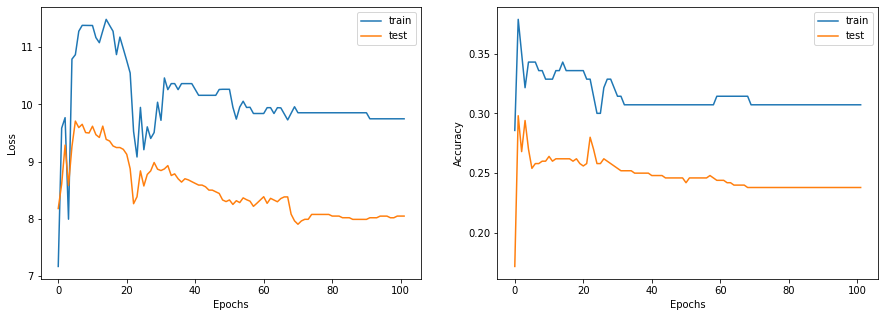

In [42]:
display_learning_curves(history)

In [43]:
_, test_accuracy = graph_emb_model.evaluate(x=[x_test_terms, x_test_emb], y=y_test, verbose=1)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")


32/32 [==============================] - 0s 2ms/step - loss: 8.3409 - acc: 0.2700
Test accuracy: 27.0%


# Classical ml models

In [44]:
from sklearn.metrics import classification_report

x_train = np.concatenate((x_train_emb, x_train_terms), axis=1)
x_test = np.concatenate((x_test_emb, x_test_terms), axis=1)

## Random forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

RT = RandomForestClassifier(max_depth=10, random_state=42)
RT.fit(x_train_emb, y_train)

pred = RT.predict(x_test_emb)
report = classification_report(y_true=y_test, y_pred=pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.24      0.38       130
           1       0.87      0.36      0.51        91
           2       0.97      0.42      0.59       144
           3       0.95      0.06      0.12       319
           4       1.00      0.16      0.28       149
           5       1.00      0.30      0.46       103
           6       1.00      0.19      0.32        64

   micro avg       0.96      0.21      0.35      1000
   macro avg       0.97      0.25      0.38      1000
weighted avg       0.96      0.21      0.33      1000
 samples avg       0.21      0.21      0.21      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train_emb, y_train)
pred = neigh.predict(x_test_emb)
report = classification_report(y_true=y_test, y_pred=pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.58      0.68       130
           1       0.70      0.84      0.76        91
           2       0.72      0.92      0.81       144
           3       0.88      0.39      0.54       319
           4       0.73      0.73      0.73       149
           5       0.78      0.67      0.72       103
           6       0.71      0.66      0.68        64

   micro avg       0.76      0.63      0.69      1000
   macro avg       0.76      0.68      0.70      1000
weighted avg       0.79      0.63      0.67      1000
 samples avg       0.63      0.63      0.63      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XG BOOST

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

xg = GradientBoostingClassifier(n_estimators=130, learning_rate=0.07, max_depth=2, random_state=5)
xg.fit(x_train_emb, np.argmax(y_train, axis=1))

pred = xg.predict(x_test_emb)
report = classification_report(y_true=np.argmax(y_test, axis=1), y_pred=pred)
print(report)

              precision    recall  f1-score   support

           0       0.49      0.54      0.51       130
           1       0.54      0.71      0.61        91
           2       0.75      0.67      0.71       144
           3       0.79      0.41      0.54       319
           4       0.44      0.62      0.51       149
           5       0.55      0.63      0.59       103
           6       0.39      0.67      0.49        64

    accuracy                           0.56      1000
   macro avg       0.56      0.61      0.57      1000
weighted avg       0.62      0.56      0.56      1000



# Conclusion

Graph structure is critical feature for node classification for the Cora dataset. It is possible to use random walks as a set of sentences and thus emloy all NLP specific embedders power to recieve better results on node classification task. One can try to train small transformer on random walks using MSE loss with adjacency  matrix as ground truth labels 